## Variational Auto Encoder [VAE]

> The **Probabilistic Deep Learning model** which addresses the issue of non-regularized latent space in Auto-Encoder and provides generative capability to the entire space.

> It comprises of *Encoder* and *Decoder*. It encodes the input vectors to latent space, where it imposes a constraint forcing it to be a normal distribution. This makes sure that the latent space is regularized. This latent space is then used to generate the output.

![Vae architecture](Others/VAE_model.jpg)


    This notebook explains the generation of new Anime faces upon providing the random normal vectors using Variational Auto Encoder.

### 1. Dataset Creation and Visualization

In [1]:
"""Import Packages"""

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Conv2D, Activation, Flatten, BatchNormalization, LeakyReLU, Multiply, Add, Reshape, Conv2DTranspose, ReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import load_model
from tqdm.notebook import tqdm
import cv2

tf.executing_eagerly()

True

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
"""Parameters"""

image_size = 64
batch_size = 256
latent_dim = 256

In [4]:
"""Images Directory"""
# Dataset Ref: https://www.kaggle.com/datasets/splcher/animefacedataset

Root_directory = "archive (2)"

In [5]:
"""Creating DataGenerator from images directory with rescaling."""

data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.0)
Train_data = data_gen.flow_from_directory(Root_directory, target_size = (image_size, image_size), batch_size = batch_size, seed = 42, interpolation = 'bilinear', shuffle = True)

Found 63565 images belonging to 1 classes.


In [6]:
image, _ = next(iter(Train_data))
image[0:25].shape

(25, 64, 64, 3)

In [7]:
output_dir = 'VAE_regenerated/'
os.makedirs(output_dir, exist_ok = True)

In [8]:
"""Functions to show and save images in batch."""

def plot_and_save_image(index, images, output_dir, save = False, show = True):
    fig, axes = plt.subplots(8, 8, figsize = (10, 10))
    sample = images[0:64]
    sample = [img for img in sample]

    idx = 0
    name = 'generated-images-{0:0=4d}.jpg'.format(index)
    for row in range(8):
        for column in range(8):
            img = sample[idx] * 255
            img = img.astype(np.uint8)
            axes[row, column].imshow(img)
            axes[row, column].axis("off")
            idx += 1
    if show:
        plt.show()
    if save:
        plt.savefig(output_dir + name)
        plt.close()

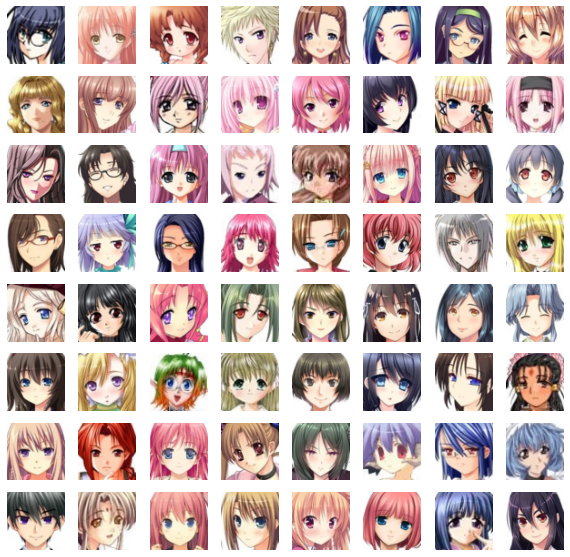

In [9]:
plot_and_save_image(0, image, output_dir, save = False, show = True)

### 2. Model

#### Enocder

In [8]:
"""Function for Encoder Convolution block"""

def conv_block(filter_size):
            conv_name = 'Conv_{}'.format(filter_size)
            batch_name = 'Batch_Norm_{}'.format(filter_size)
            relu_name = 'Leaky_Relu_{}'.format(filter_size)
            conv = Conv2D(filters = filter_size, kernel_size = 4, strides = 2, padding = 'same', data_format = 'channels_last', use_bias = False,
                          kernel_initializer=tf.keras.initializers.he_normal(seed=33), name = conv_name)
            leakyrelu_activation = LeakyReLU(0.2, name = relu_name)
            batch_norm = BatchNormalization(name = batch_name)

            return conv, leakyrelu_activation, batch_norm

> The latent vector or code is sampled from Encoder generated Distribution. This random sampling makes it difficult for back-propagation, since errors can't be trace back due to this random sampling. Hence, **Reparameterization** technique is used to model the sampling process which makes it possible for errors to propagte to network.

$$ \small \text{Random Sampling of Normal Distribution}, \large \varepsilon \in \normalsize \mathcal{N}(0, 1) $$
$$ \small \text{Reparameterization Trick} $$
$$ \large z = \mu \scriptsize + \large \varepsilon \cdot \sigma $$ 

In [9]:
"""Creation of Encoder Class"""

class Encoder(Model):

    def __init__(self, image_size: int, latent_dim: int):
        super(Encoder, self).__init__()

        self.filters = [32, 64, 128, 256, 512]
        self.image_size = image_size
        self.encoder_input = Input(shape = (image_size, image_size, 3))
        self.Conv_Layers = [conv_block(filter) for filter in self.filters]
        self.flatten = Flatten(data_format = 'channels_last')
        self.FC_1 = Dense(1024, name = 'FC-1')
        self.batch_norm = BatchNormalization(name = 'FC-1-Batchnorm')
        self.Mu_Dense = Dense(latent_dim, name = 'FC-Mu')
        self.Log_Var_Dense = Dense(latent_dim, name = 'FC-Log-Var')
        self.z_multiply = Multiply()
        self.z_add = Add()
    
    def call(self, image):
        self.encoder_input = image
        out = self.Conv_Layers[0][0](self.encoder_input)
        out = self.Conv_Layers[0][1](out)
        out = self.Conv_Layers[0][2](out)
        for i in range(1, len(self.filters[1:]) + 1):
            out = self.Conv_Layers[i][0](out)
            out = self.Conv_Layers[i][1](out)
            out = self.Conv_Layers[i][2](out)
        out = self.flatten(out)
        out = self.FC_1(out)

        mu = self.Mu_Dense(out) # Creation of mu
        log_var = self.Log_Var_Dense(out) # Creation of Log_Variance(i.e. Log of sigma square)

        epsilon = tf.keras.backend.random_normal(shape = (tf.shape(log_var)[0], tf.shape(log_var)[1]), mean = 0.0, stddev = 1.0) # Random normal sampling for epsilon
        sigma = tf.exp(0.5 * log_var) # Creation of Sigma from Log_Variance(i.e. sigma = exp(log(sqrt(sigma square))))

        z_2 = self.z_multiply([epsilon, sigma])
        z = self.z_add([mu, z_2])

        return z, mu, log_var  

#### Decoder

In [10]:
"""Creation of Decoder Class"""

class Decoder(Model):

    def __init__(self, latent_dim: int):
        super(Decoder, self).__init__()
        
        self.decode = Sequential()
        self.decode.add(Input(shape = (latent_dim,)))
        self.decode.add(Dense(512, name = 'FC_1'))
        self.decode.add(Dense(latent_dim*4*4, name = 'FC_2'))
        self.decode.add(Reshape((4, 4, latent_dim)))
        self.decode.add(Conv2DTranspose(filters = 128, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', use_bias = False, name = 'Conv_Tr_128'))
        self.decode.add(ReLU())
        self.decode.add(BatchNormalization())
        self.decode.add(Conv2DTranspose(filters = 64, kernel_size = (4, 4), strides = (2, 2), padding = 'same', use_bias = False, name = 'Conv_Tr_64'))
        self.decode.add(ReLU())
        self.decode.add(BatchNormalization())
        self.decode.add(Conv2DTranspose(filters = 32, kernel_size = (4, 4), strides = (2, 2), padding = 'same', use_bias = False, name = 'Conv_Tr_32'))
        self.decode.add(ReLU())
        self.decode.add(BatchNormalization())
        self.decode.add(Conv2DTranspose(filters = 16, kernel_size = (4, 4), strides = (2, 2), padding = 'same', use_bias = False, name = 'Conv_Tr_16'))
        self.decode.add(ReLU())
        self.decode.add(BatchNormalization())
        self.decode.add(Conv2DTranspose(filters = 8, kernel_size = (4, 4), strides = (2, 2), padding = 'same', use_bias = False, name = 'Conv_Tr_8'))
        self.decode.add(ReLU())
        self.decode.add(BatchNormalization())
        self.decode.add(Conv2DTranspose(filters = 3, kernel_size = (4, 4), strides = (1, 1), activation = 'sigmoid', use_bias = False, padding = 'same', name = 'Conv_Tr_3'))
        self.decode.add(BatchNormalization())
        self.decode.add(Activation('sigmoid'))


    def call(self, latent_vector):
        out = self.decode(latent_vector)

        return out


#### Loss computation

$$ \text{Regeneration Loss} = \text{MSE}(x-\hat{x}) $$

$ \text{KL Divergence} = D_{KL}(\mathcal{N}(\mu_{x}, \sigma_{x}) || \mathcal{N}(0,1)) $

$$ D_{KL} = -0.5 \cdot \sum_{1}^{batch}(\frac{1}{N}\sum_{n=1}^{N} (1 \footnotesize + \normalsize \log(\sigma^{2}_{n}) - \mu^{2}_{n} - \sigma^{2}_{n}))

In [11]:
"""Function to calculate Mean Squared Error for real image and generated image."""
def regeneration_loss(y_true, y_pred):
    error = y_true - y_pred
    loss = K.mean(K.square(error))
    return loss

"""Function to calculate KL-Divergence Loss for reparametrization variables(mu and sigma[log_variance])."""
def KL_loss(mu, log_var):
    kl_loss = -0.5 * K.mean(1 + log_var - K.square(mu) - K.exp(log_var))
    return kl_loss

"""Function to calculate Total Loss."""
def Total_Loss(y_true, y_pred, kl_loss):
    total_loss = kl_loss + regeneration_loss(y_true, y_pred)
    return total_loss

#### Variational Auto Encoder 

In [12]:
"""Creation of VAE using Encoder and Decoder modules."""

tf.keras.backend.clear_session()
class VAE(Model):

    def __init__(self, image_size: int, latent_dim: int):
        super(VAE, self).__init__()

        self.img_size = image_size
        self.latent_dim = latent_dim
        self.encoder = Encoder(self.img_size, self.latent_dim)
        self.decoder = Decoder(self.latent_dim)

    def call(self, image):
        z_code, mu, log_var = self.encoder(image)
        self.add_loss(KL_loss(mu, log_var)) # Adding KL-loss as a part of model.
        out = self.decoder(z_code)

        return out, mu, log_var


In [15]:
vae = VAE(image_size, latent_dim)

In [16]:
"""Fixed Random latent vector to visualize generated images during training."""

fixed_latent_vector = tf.random.normal(shape = (64, latent_dim))
regenerated_images = vae.layers[-1](fixed_latent_vector)
regenerated_images.shape

TensorShape([64, 64, 64, 3])

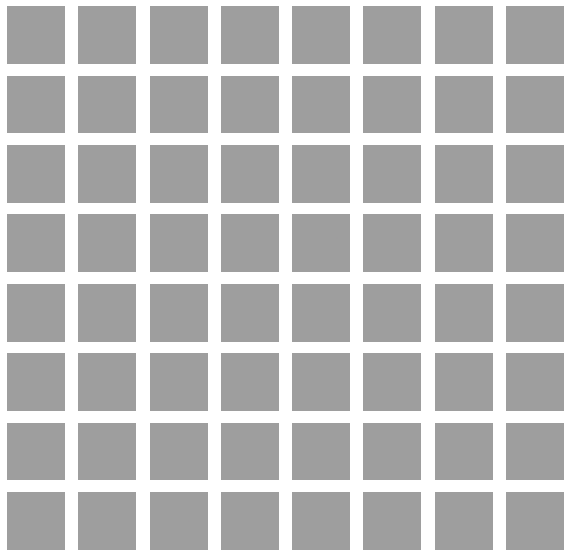

In [17]:
"""Plot of above latent vector before training."""

plot_and_save_image(0, regenerated_images.numpy(), output_dir, save = True, show = True)

### 3. Training

In [18]:
"""Fit function"""

def Fit(epochs, start_idx, lr, steps_per_epoch):
    tf.keras.backend.clear_session()
    optimizer = tf.keras.optimizers.Adam(lr, beta_1 = 0.95, beta_2 = 0.999)
    KL_Losses = []
    Total_Losses = []
    MSE_Losses = []

    for epoch in range(epochs):
        step = 0
        for x, _ in tqdm(Train_data): # Iterating over batch of data.
            with tf.GradientTape() as tape:
                y_pred, mu, log_var = vae(x, training = True)

                x = tf.reshape(x, shape = [-1])
                y_pred = tf.reshape(y_pred, shape = [-1])

                loss_mse = regeneration_loss(x, y_pred)
                loss_kl = sum(vae.losses) * 0.009 # Scaling of KL loss
                loss_total = Total_Loss(x, y_pred, loss_kl)

            gradients = tape.gradient(loss_total, vae.trainable_variables)
            optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
            if step >= steps_per_epoch: # To stop the custom training loop over batches generated by ImageDataGenerator. If it's not added the loop get's running non-stop.
                    break 
            step += 1
        Train_data.on_epoch_end()
        
        KL_Losses.append(loss_kl.numpy())
        MSE_Losses.append(loss_mse.numpy())
        Total_Losses.append(loss_total.numpy())
        regenerated_images = vae.layers[-1](fixed_latent_vector)
        
        print("Epoch [{}/{}], MSE_loss: {:.4f}, KL_loss: {:.4f}, Total_loss: {:.4f}".format(
              epoch + 1, epochs, loss_mse, loss_kl, loss_total))
            
        plot_and_save_image(start_idx, regenerated_images.numpy(), output_dir, save = True, show = False)    
        start_idx += 1


    return Total_Losses, MSE_Losses, KL_Losses    

In [19]:
epochs = 200
lr = 3e-4
steps_per_epoch = 63565 // batch_size
steps_per_epoch = steps_per_epoch + 1

In [20]:
"""Kickstart of Training"""
history = Fit(epochs, 1, lr, steps_per_epoch)

  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [1/200], MSE_loss: 0.0419, KL_loss: 0.0029, Total_loss: 0.0448


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [2/200], MSE_loss: 0.0350, KL_loss: 0.0028, Total_loss: 0.0379


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [3/200], MSE_loss: 0.0290, KL_loss: 0.0030, Total_loss: 0.0320


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [4/200], MSE_loss: 0.0254, KL_loss: 0.0030, Total_loss: 0.0283


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [5/200], MSE_loss: 0.0230, KL_loss: 0.0030, Total_loss: 0.0260


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [6/200], MSE_loss: 0.0220, KL_loss: 0.0031, Total_loss: 0.0251


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [7/200], MSE_loss: 0.0249, KL_loss: 0.0063, Total_loss: 0.0312


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [8/200], MSE_loss: 0.0203, KL_loss: 0.0032, Total_loss: 0.0236


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [9/200], MSE_loss: 0.0189, KL_loss: 0.0033, Total_loss: 0.0222


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [10/200], MSE_loss: 0.0181, KL_loss: 0.0034, Total_loss: 0.0215


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [11/200], MSE_loss: 0.0180, KL_loss: 0.0034, Total_loss: 0.0214


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [12/200], MSE_loss: 0.0177, KL_loss: 0.0034, Total_loss: 0.0211


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [13/200], MSE_loss: 0.0181, KL_loss: 0.0036, Total_loss: 0.0217


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [14/200], MSE_loss: 0.0168, KL_loss: 0.0033, Total_loss: 0.0201


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [15/200], MSE_loss: 0.0164, KL_loss: 0.0036, Total_loss: 0.0200


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [16/200], MSE_loss: 0.0163, KL_loss: 0.0037, Total_loss: 0.0201


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [17/200], MSE_loss: 0.0163, KL_loss: 0.0036, Total_loss: 0.0199


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [18/200], MSE_loss: 0.0160, KL_loss: 0.0035, Total_loss: 0.0195


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [19/200], MSE_loss: 0.0155, KL_loss: 0.0035, Total_loss: 0.0191


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [20/200], MSE_loss: 0.0201, KL_loss: 0.0092, Total_loss: 0.0293


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [21/200], MSE_loss: 0.0156, KL_loss: 0.0037, Total_loss: 0.0193


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [22/200], MSE_loss: 0.0153, KL_loss: 0.0036, Total_loss: 0.0189


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [23/200], MSE_loss: 0.0151, KL_loss: 0.0036, Total_loss: 0.0188


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [24/200], MSE_loss: 0.0156, KL_loss: 0.0036, Total_loss: 0.0192


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [25/200], MSE_loss: 0.0162, KL_loss: 0.0054, Total_loss: 0.0215


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [26/200], MSE_loss: 0.0150, KL_loss: 0.0037, Total_loss: 0.0187


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [27/200], MSE_loss: 0.0149, KL_loss: 0.0037, Total_loss: 0.0187


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [28/200], MSE_loss: 0.0146, KL_loss: 0.0037, Total_loss: 0.0184


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [29/200], MSE_loss: 0.0144, KL_loss: 0.0038, Total_loss: 0.0183


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [30/200], MSE_loss: 0.0145, KL_loss: 0.0037, Total_loss: 0.0182


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [31/200], MSE_loss: 0.0149, KL_loss: 0.0042, Total_loss: 0.0191


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [32/200], MSE_loss: 0.0144, KL_loss: 0.0037, Total_loss: 0.0181


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [33/200], MSE_loss: 0.0141, KL_loss: 0.0038, Total_loss: 0.0179


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [34/200], MSE_loss: 0.0143, KL_loss: 0.0036, Total_loss: 0.0179


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [35/200], MSE_loss: 0.0145, KL_loss: 0.0039, Total_loss: 0.0184


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [36/200], MSE_loss: 0.0133, KL_loss: 0.0038, Total_loss: 0.0171


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [37/200], MSE_loss: 0.0139, KL_loss: 0.0039, Total_loss: 0.0177


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [38/200], MSE_loss: 0.0141, KL_loss: 0.0038, Total_loss: 0.0179


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [39/200], MSE_loss: 0.0139, KL_loss: 0.0038, Total_loss: 0.0177


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [40/200], MSE_loss: 0.0144, KL_loss: 0.0038, Total_loss: 0.0182


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [41/200], MSE_loss: 0.0138, KL_loss: 0.0038, Total_loss: 0.0176


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [42/200], MSE_loss: 0.0132, KL_loss: 0.0040, Total_loss: 0.0171


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [43/200], MSE_loss: 0.0135, KL_loss: 0.0038, Total_loss: 0.0173


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [44/200], MSE_loss: 0.0138, KL_loss: 0.0039, Total_loss: 0.0177


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [45/200], MSE_loss: 0.0136, KL_loss: 0.0040, Total_loss: 0.0176


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [46/200], MSE_loss: 0.0154, KL_loss: 0.0041, Total_loss: 0.0194


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [47/200], MSE_loss: 0.0132, KL_loss: 0.0037, Total_loss: 0.0169


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [48/200], MSE_loss: 0.0137, KL_loss: 0.0039, Total_loss: 0.0177


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [49/200], MSE_loss: 0.0133, KL_loss: 0.0039, Total_loss: 0.0172


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [50/200], MSE_loss: 0.0132, KL_loss: 0.0038, Total_loss: 0.0170


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [51/200], MSE_loss: 0.0128, KL_loss: 0.0037, Total_loss: 0.0165


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [52/200], MSE_loss: 0.0134, KL_loss: 0.0039, Total_loss: 0.0173


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [53/200], MSE_loss: 0.0137, KL_loss: 0.0040, Total_loss: 0.0177


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [54/200], MSE_loss: 0.0141, KL_loss: 0.0040, Total_loss: 0.0180


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [55/200], MSE_loss: 0.0130, KL_loss: 0.0039, Total_loss: 0.0169


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [56/200], MSE_loss: 0.0132, KL_loss: 0.0039, Total_loss: 0.0171


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [57/200], MSE_loss: 0.0132, KL_loss: 0.0039, Total_loss: 0.0171


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [58/200], MSE_loss: 0.0149, KL_loss: 0.0043, Total_loss: 0.0192


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [59/200], MSE_loss: 0.0130, KL_loss: 0.0039, Total_loss: 0.0169


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [60/200], MSE_loss: 0.0133, KL_loss: 0.0039, Total_loss: 0.0172


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [61/200], MSE_loss: 0.0131, KL_loss: 0.0040, Total_loss: 0.0171


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [62/200], MSE_loss: 0.0131, KL_loss: 0.0039, Total_loss: 0.0170


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [63/200], MSE_loss: 0.0127, KL_loss: 0.0040, Total_loss: 0.0167


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [64/200], MSE_loss: 0.0131, KL_loss: 0.0039, Total_loss: 0.0171


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [65/200], MSE_loss: 0.0139, KL_loss: 0.0043, Total_loss: 0.0182


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [66/200], MSE_loss: 0.0126, KL_loss: 0.0040, Total_loss: 0.0167


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [67/200], MSE_loss: 0.0132, KL_loss: 0.0040, Total_loss: 0.0173


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [68/200], MSE_loss: 0.0129, KL_loss: 0.0040, Total_loss: 0.0169


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [69/200], MSE_loss: 0.0125, KL_loss: 0.0041, Total_loss: 0.0166


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [70/200], MSE_loss: 0.0138, KL_loss: 0.0040, Total_loss: 0.0178


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [71/200], MSE_loss: 0.0135, KL_loss: 0.0039, Total_loss: 0.0174


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [72/200], MSE_loss: 0.0135, KL_loss: 0.0043, Total_loss: 0.0178


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [73/200], MSE_loss: 0.0131, KL_loss: 0.0039, Total_loss: 0.0171


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [74/200], MSE_loss: 0.0136, KL_loss: 0.0041, Total_loss: 0.0178


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [75/200], MSE_loss: 0.0128, KL_loss: 0.0039, Total_loss: 0.0167


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [76/200], MSE_loss: 0.0129, KL_loss: 0.0040, Total_loss: 0.0169


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [77/200], MSE_loss: 0.0127, KL_loss: 0.0040, Total_loss: 0.0167


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [78/200], MSE_loss: 0.0130, KL_loss: 0.0040, Total_loss: 0.0170


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [79/200], MSE_loss: 0.0130, KL_loss: 0.0039, Total_loss: 0.0169


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [80/200], MSE_loss: 0.0128, KL_loss: 0.0039, Total_loss: 0.0167


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [81/200], MSE_loss: 0.0129, KL_loss: 0.0040, Total_loss: 0.0168


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [82/200], MSE_loss: 0.0128, KL_loss: 0.0041, Total_loss: 0.0169


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [83/200], MSE_loss: 0.0128, KL_loss: 0.0039, Total_loss: 0.0167


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [84/200], MSE_loss: 0.0125, KL_loss: 0.0041, Total_loss: 0.0166


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [85/200], MSE_loss: 0.0123, KL_loss: 0.0040, Total_loss: 0.0163


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [86/200], MSE_loss: 0.0126, KL_loss: 0.0041, Total_loss: 0.0167


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [87/200], MSE_loss: 0.0127, KL_loss: 0.0041, Total_loss: 0.0168


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [88/200], MSE_loss: 0.0124, KL_loss: 0.0041, Total_loss: 0.0165


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [89/200], MSE_loss: 0.0130, KL_loss: 0.0039, Total_loss: 0.0170


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [90/200], MSE_loss: 0.0136, KL_loss: 0.0040, Total_loss: 0.0176


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [91/200], MSE_loss: 0.0130, KL_loss: 0.0040, Total_loss: 0.0170


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [92/200], MSE_loss: 0.0127, KL_loss: 0.0042, Total_loss: 0.0169


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [93/200], MSE_loss: 0.0123, KL_loss: 0.0041, Total_loss: 0.0164


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [94/200], MSE_loss: 0.0132, KL_loss: 0.0041, Total_loss: 0.0173


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [95/200], MSE_loss: 0.0128, KL_loss: 0.0041, Total_loss: 0.0169


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [96/200], MSE_loss: 0.0128, KL_loss: 0.0040, Total_loss: 0.0168


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [97/200], MSE_loss: 0.0124, KL_loss: 0.0042, Total_loss: 0.0166


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [98/200], MSE_loss: 0.0131, KL_loss: 0.0040, Total_loss: 0.0172


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [99/200], MSE_loss: 0.0128, KL_loss: 0.0039, Total_loss: 0.0167


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [100/200], MSE_loss: 0.0128, KL_loss: 0.0042, Total_loss: 0.0171


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [101/200], MSE_loss: 0.0124, KL_loss: 0.0041, Total_loss: 0.0165


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [102/200], MSE_loss: 0.0124, KL_loss: 0.0041, Total_loss: 0.0165


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [103/200], MSE_loss: 0.0124, KL_loss: 0.0041, Total_loss: 0.0165


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [104/200], MSE_loss: 0.0134, KL_loss: 0.0040, Total_loss: 0.0174


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [105/200], MSE_loss: 0.0128, KL_loss: 0.0042, Total_loss: 0.0170


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [106/200], MSE_loss: 0.0127, KL_loss: 0.0040, Total_loss: 0.0167


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [107/200], MSE_loss: 0.0125, KL_loss: 0.0041, Total_loss: 0.0165


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [108/200], MSE_loss: 0.0127, KL_loss: 0.0042, Total_loss: 0.0169


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [109/200], MSE_loss: 0.0128, KL_loss: 0.0041, Total_loss: 0.0169


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [110/200], MSE_loss: 0.0124, KL_loss: 0.0040, Total_loss: 0.0164


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [111/200], MSE_loss: 0.0136, KL_loss: 0.0041, Total_loss: 0.0177


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [112/200], MSE_loss: 0.0123, KL_loss: 0.0040, Total_loss: 0.0164


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [113/200], MSE_loss: 0.0124, KL_loss: 0.0041, Total_loss: 0.0165


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [114/200], MSE_loss: 0.0120, KL_loss: 0.0041, Total_loss: 0.0161


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [115/200], MSE_loss: 0.0125, KL_loss: 0.0042, Total_loss: 0.0167


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [116/200], MSE_loss: 0.0124, KL_loss: 0.0041, Total_loss: 0.0165


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [117/200], MSE_loss: 0.0122, KL_loss: 0.0041, Total_loss: 0.0163


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [118/200], MSE_loss: 0.0119, KL_loss: 0.0042, Total_loss: 0.0160


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [119/200], MSE_loss: 0.0123, KL_loss: 0.0041, Total_loss: 0.0164


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [120/200], MSE_loss: 0.0123, KL_loss: 0.0041, Total_loss: 0.0164


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [121/200], MSE_loss: 0.0121, KL_loss: 0.0041, Total_loss: 0.0162


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [122/200], MSE_loss: 0.0123, KL_loss: 0.0041, Total_loss: 0.0165


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [123/200], MSE_loss: 0.0123, KL_loss: 0.0041, Total_loss: 0.0164


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [124/200], MSE_loss: 0.0123, KL_loss: 0.0042, Total_loss: 0.0165


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [125/200], MSE_loss: 0.0123, KL_loss: 0.0042, Total_loss: 0.0165


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [126/200], MSE_loss: 0.0125, KL_loss: 0.0041, Total_loss: 0.0167


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [127/200], MSE_loss: 0.0120, KL_loss: 0.0041, Total_loss: 0.0161


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [128/200], MSE_loss: 0.0123, KL_loss: 0.0041, Total_loss: 0.0164


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [129/200], MSE_loss: 0.0124, KL_loss: 0.0042, Total_loss: 0.0166


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [130/200], MSE_loss: 0.0124, KL_loss: 0.0043, Total_loss: 0.0166


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [131/200], MSE_loss: 0.0127, KL_loss: 0.0041, Total_loss: 0.0168


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [132/200], MSE_loss: 0.0121, KL_loss: 0.0041, Total_loss: 0.0162


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [133/200], MSE_loss: 0.0120, KL_loss: 0.0041, Total_loss: 0.0161


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [134/200], MSE_loss: 0.0130, KL_loss: 0.0047, Total_loss: 0.0177


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [135/200], MSE_loss: 0.0121, KL_loss: 0.0042, Total_loss: 0.0163


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [136/200], MSE_loss: 0.0120, KL_loss: 0.0041, Total_loss: 0.0161


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [137/200], MSE_loss: 0.0123, KL_loss: 0.0041, Total_loss: 0.0164


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [138/200], MSE_loss: 0.0120, KL_loss: 0.0041, Total_loss: 0.0161


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [139/200], MSE_loss: 0.0119, KL_loss: 0.0042, Total_loss: 0.0161


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [140/200], MSE_loss: 0.0123, KL_loss: 0.0042, Total_loss: 0.0165


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [141/200], MSE_loss: 0.0115, KL_loss: 0.0041, Total_loss: 0.0156


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [142/200], MSE_loss: 0.0118, KL_loss: 0.0042, Total_loss: 0.0161


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [143/200], MSE_loss: 0.0122, KL_loss: 0.0043, Total_loss: 0.0165


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [144/200], MSE_loss: 0.0118, KL_loss: 0.0042, Total_loss: 0.0160


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [145/200], MSE_loss: 0.0123, KL_loss: 0.0043, Total_loss: 0.0166


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [146/200], MSE_loss: 0.0121, KL_loss: 0.0041, Total_loss: 0.0162


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [147/200], MSE_loss: 0.0121, KL_loss: 0.0042, Total_loss: 0.0163


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [148/200], MSE_loss: 0.0121, KL_loss: 0.0042, Total_loss: 0.0163


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [149/200], MSE_loss: 0.0124, KL_loss: 0.0043, Total_loss: 0.0167


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [150/200], MSE_loss: 0.0117, KL_loss: 0.0042, Total_loss: 0.0159


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [151/200], MSE_loss: 0.0114, KL_loss: 0.0043, Total_loss: 0.0157


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [152/200], MSE_loss: 0.0120, KL_loss: 0.0043, Total_loss: 0.0163


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [153/200], MSE_loss: 0.0125, KL_loss: 0.0042, Total_loss: 0.0167


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [154/200], MSE_loss: 0.0123, KL_loss: 0.0042, Total_loss: 0.0165


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [155/200], MSE_loss: 0.0121, KL_loss: 0.0042, Total_loss: 0.0164


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [156/200], MSE_loss: 0.0131, KL_loss: 0.0043, Total_loss: 0.0173


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [157/200], MSE_loss: 0.0123, KL_loss: 0.0043, Total_loss: 0.0166


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [158/200], MSE_loss: 0.0125, KL_loss: 0.0042, Total_loss: 0.0167


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [159/200], MSE_loss: 0.0121, KL_loss: 0.0042, Total_loss: 0.0163


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [160/200], MSE_loss: 0.0119, KL_loss: 0.0043, Total_loss: 0.0161


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [161/200], MSE_loss: 0.0121, KL_loss: 0.0043, Total_loss: 0.0164


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [162/200], MSE_loss: 0.0123, KL_loss: 0.0043, Total_loss: 0.0166


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [163/200], MSE_loss: 0.0119, KL_loss: 0.0042, Total_loss: 0.0160


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [164/200], MSE_loss: 0.0117, KL_loss: 0.0042, Total_loss: 0.0159


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [165/200], MSE_loss: 0.0116, KL_loss: 0.0043, Total_loss: 0.0158


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [166/200], MSE_loss: 0.0122, KL_loss: 0.0043, Total_loss: 0.0165


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [167/200], MSE_loss: 0.0118, KL_loss: 0.0043, Total_loss: 0.0161


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [168/200], MSE_loss: 0.0115, KL_loss: 0.0042, Total_loss: 0.0157


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [169/200], MSE_loss: 0.0122, KL_loss: 0.0043, Total_loss: 0.0166


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [170/200], MSE_loss: 0.0116, KL_loss: 0.0041, Total_loss: 0.0158


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [171/200], MSE_loss: 0.0123, KL_loss: 0.0042, Total_loss: 0.0165


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [172/200], MSE_loss: 0.0117, KL_loss: 0.0042, Total_loss: 0.0159


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [173/200], MSE_loss: 0.0117, KL_loss: 0.0043, Total_loss: 0.0160


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [174/200], MSE_loss: 0.0115, KL_loss: 0.0042, Total_loss: 0.0158


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [175/200], MSE_loss: 0.0123, KL_loss: 0.0043, Total_loss: 0.0166


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [176/200], MSE_loss: 0.0122, KL_loss: 0.0042, Total_loss: 0.0164


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [177/200], MSE_loss: 0.0120, KL_loss: 0.0044, Total_loss: 0.0163


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [178/200], MSE_loss: 0.0117, KL_loss: 0.0043, Total_loss: 0.0160


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [179/200], MSE_loss: 0.0115, KL_loss: 0.0044, Total_loss: 0.0159


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [180/200], MSE_loss: 0.0113, KL_loss: 0.0042, Total_loss: 0.0156


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [181/200], MSE_loss: 0.0121, KL_loss: 0.0043, Total_loss: 0.0164


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [182/200], MSE_loss: 0.0117, KL_loss: 0.0043, Total_loss: 0.0160


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [183/200], MSE_loss: 0.0119, KL_loss: 0.0043, Total_loss: 0.0162


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [184/200], MSE_loss: 0.0118, KL_loss: 0.0042, Total_loss: 0.0160


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [185/200], MSE_loss: 0.0119, KL_loss: 0.0042, Total_loss: 0.0161


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [186/200], MSE_loss: 0.0120, KL_loss: 0.0042, Total_loss: 0.0162


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [187/200], MSE_loss: 0.0116, KL_loss: 0.0043, Total_loss: 0.0159


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [188/200], MSE_loss: 0.0117, KL_loss: 0.0043, Total_loss: 0.0159


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [189/200], MSE_loss: 0.0118, KL_loss: 0.0042, Total_loss: 0.0160


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [190/200], MSE_loss: 0.0113, KL_loss: 0.0043, Total_loss: 0.0156


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [191/200], MSE_loss: 0.0116, KL_loss: 0.0043, Total_loss: 0.0158


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [192/200], MSE_loss: 0.0119, KL_loss: 0.0044, Total_loss: 0.0162


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [193/200], MSE_loss: 0.0116, KL_loss: 0.0043, Total_loss: 0.0159


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [194/200], MSE_loss: 0.0118, KL_loss: 0.0043, Total_loss: 0.0161


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [195/200], MSE_loss: 0.0122, KL_loss: 0.0043, Total_loss: 0.0165


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [196/200], MSE_loss: 0.0124, KL_loss: 0.0042, Total_loss: 0.0166


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [197/200], MSE_loss: 0.0121, KL_loss: 0.0043, Total_loss: 0.0164


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [198/200], MSE_loss: 0.0114, KL_loss: 0.0043, Total_loss: 0.0157


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [199/200], MSE_loss: 0.0150, KL_loss: 0.0078, Total_loss: 0.0227


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [200/200], MSE_loss: 0.0118, KL_loss: 0.0043, Total_loss: 0.0161


In [21]:
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  5413760   
                                                                 
 decoder (Decoder)           multiple                  2441068   
                                                                 
Total params: 7,854,828
Trainable params: 7,852,342
Non-trainable params: 2,486
_________________________________________________________________


In [22]:
vae.layers[0].summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_32 (Conv2D)            multiple                  1536      
                                                                 
 Leaky_Relu_32 (LeakyReLU)   multiple                  0         
                                                                 
 Batch_Norm_32 (BatchNormali  multiple                 128       
 zation)                                                         
                                                                 
 Conv_64 (Conv2D)            multiple                  32768     
                                                                 
 Leaky_Relu_64 (LeakyReLU)   multiple                  0         
                                                                 
 Batch_Norm_64 (BatchNormali  multiple                 256       
 zation)                                                   

In [23]:
vae.layers[1].summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         2441068   
                                                                 
Total params: 2,441,068
Trainable params: 2,440,566
Non-trainable params: 502
_________________________________________________________________


In [109]:
vae.save('VAE_Trained', save_format='tf')

INFO:tensorflow:Assets written to: VAE_Trained\assets


### 4. Visualization of Losses

In [29]:
loss_total, loss_mse, loss_kl = history

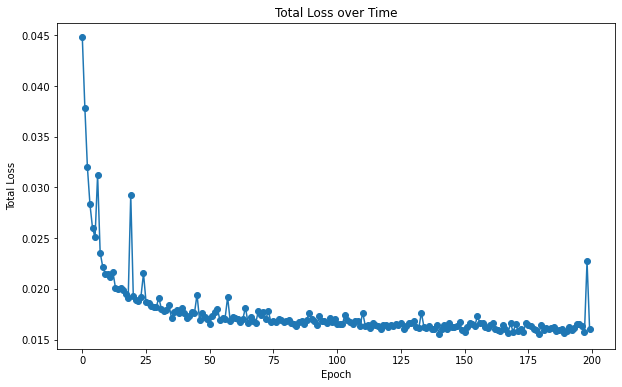

In [30]:
x = range(len(loss_total))

plt.figure(figsize=(10,6))
plt.plot(x, loss_total ,'-')
plt.scatter(x, loss_total)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Total Loss over Time')
plt.show()

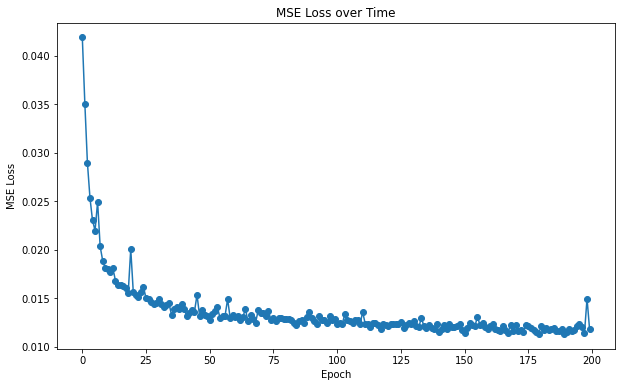

In [31]:
x = range(len(loss_mse))

plt.figure(figsize=(10,6))
plt.plot(x, loss_mse ,'-')
plt.scatter(x, loss_mse)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('MSE Loss over Time')
plt.show()

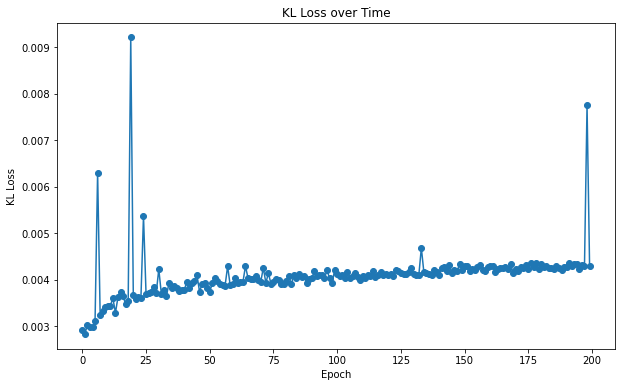

In [32]:
x = range(len(loss_kl))

plt.figure(figsize=(10,6))
plt.plot(x, loss_kl ,'-')
plt.scatter(x, loss_kl)
plt.xlabel('Epoch')
plt.ylabel('KL Loss')
plt.title('KL Loss over Time')
plt.show()

### 5. Inference and Image Generation

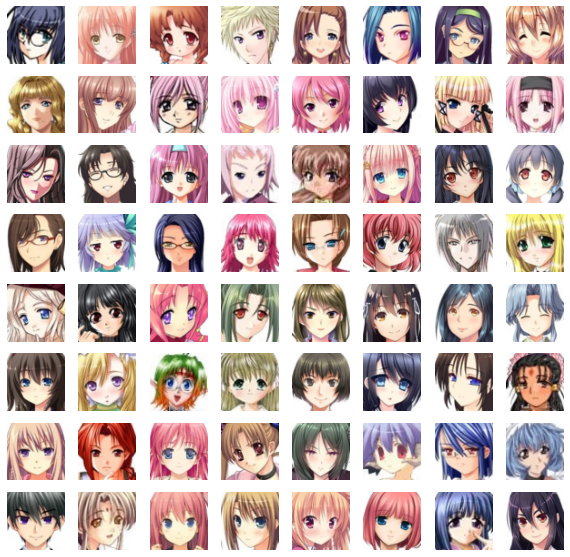

In [61]:
"""Plot of original images"""
plot_and_save_image(0, image, output_dir, save = False, show = True)

In [62]:
regenerated_images, _, _ = vae(image)
regenerated_images.shape

TensorShape([256, 64, 64, 3])

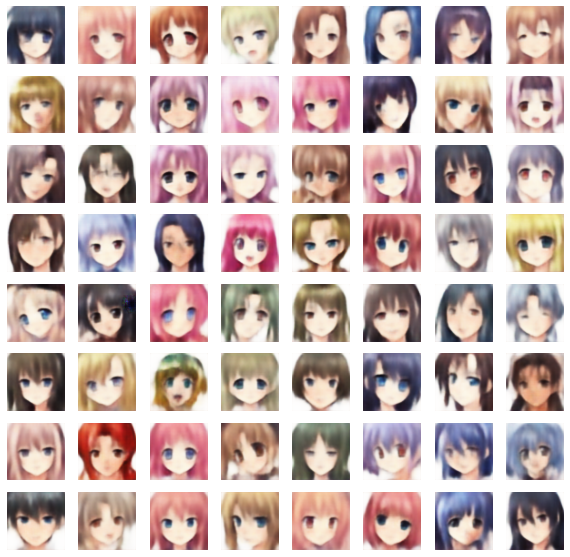

In [65]:
"""Plot of regenerated images of above given image vectors"""
plot_and_save_image(0, regenerated_images.numpy(), output_dir, save = False, show = True)

In [66]:
latent_vector = tf.random.normal(shape = (64, latent_dim))
regenerated_images = vae.layers[-1](latent_vector)
regenerated_images.shape

TensorShape([64, 64, 64, 3])

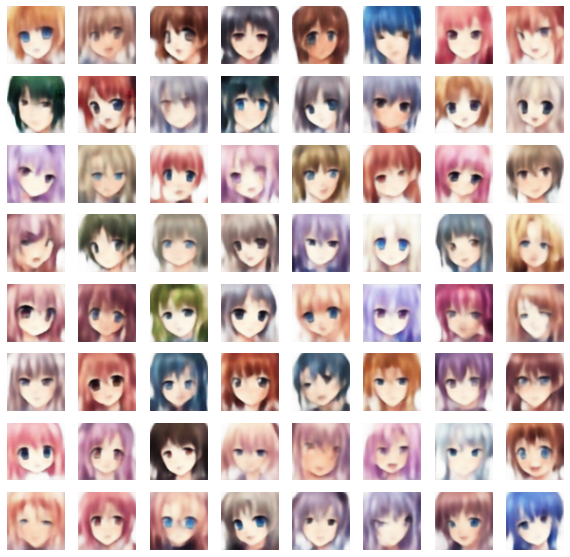

In [67]:
"""Generating new images for the random latent code"""
plot_and_save_image(0, regenerated_images.numpy(), output_dir, save = False, show = True)

In [2]:
"""Create Video for Generated Images."""
output_dir = 'VAE_regenerated/'
vid_fname = 'vae.mp4'

files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 10, (720, 720))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

### 6. References:
1. [You Tube](https://youtu.be/d0W_Ab-aZGo?si=yv2U46TCMk_VCIye)
2. [You Tube](https://youtu.be/VELQT1-hILo?si=PobJ16BvYpoeRf0J)
3. [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)